# LSST Milky Way Satellite Luminosity Function

Author: Alex Drlica-Wagner

This notebook estimates the expected number of Milky Way satellite galaxies that will be observed by LSST as described in [Tsiane et al. (2025)](https://arxiv.org/abs/2504.16203). We use the subhalo-satellite connection model from [Nadler et al. (2020)](https://arxiv.org/abs/1912.03303). Predictions for the LSST survey footprint come from the baseline v4.0 opsim model along with the foreground object association map from DES and PS1 in [Drlica-Wagner et al. (2020)](https://arxiv.org/abs/1912.03302). 

In [1]:
#Imports
import copy
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import Patch, PathPatch
import xgboost as xgb
import pandas as pd
import healpy as hp
from numpy import linalg as LA
from IPython.core.debugger import set_trace
import scipy.ndimage as nd

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}

plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "cmr10"
plt.rcParams["axes.formatter.use_mathtext"] = True

plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14

rubin_teal = '#058B8C'
rubin_turquoise = '#00BABC'

In [2]:
# Load the subhalo_satellite_connection module
SATSIM = "/project/shared/data/satsim"
MODEL = f"{SATSIM}/dc2_paper/subhalo_satellite_connection"

from load_hyperparams import *
from masks import load_survey_masks, evaluate_mask, read_map
from satellite_realization import satellite_realization, evaluate_ln_likelihood, evaluate_ln_prior, mcmc
from ssf import apply_ssfs

In [3]:
#Load hyperparameters
hparams, prior_hparams, cosmo_params, orphan_params, halo_data, sim_indices, vpeak_Mr_interp = load_hyperparams()

#Set parameters
params = load_params()
default_param_vector = np.array(list(load_params().values()))

In [4]:
#Load masks and ssfs
print('loading masks and ssfs ... \n')
masks,ssfs = load_survey_masks(['des','ps1','lsst_meas','lsst_meas_corr','lsst_ideal'])

# Add some aliases
masks['lsst'] = masks['lsst_ideal']
ssfs['lsst'] = ssfs['lsst_ideal']

# Add some custom masks to mix and match real and perfect SSFs and footprints.
perfect_ssf = copy.deepcopy(ssfs['lsst'])
def predict(*args, **kwargs):
    if 'abs_mag' in kwargs:
        return np.ones_like(kwargs['abs_mag'])
    else:
        return 1.0
perfect_ssf.predict = predict

allsky_mask = copy.deepcopy(masks['lsst'])
allsky_mask[:] = 0

ssfs['perfect'] = perfect_ssf
masks['perfect'] = allsky_mask

ssfs['perfect_lsst'] = copy.deepcopy(perfect_ssf)
masks['perfect_lsst'] = copy.deepcopy(masks['lsst'])

ssfs['lsst_allsky'] = copy.deepcopy(ssfs['lsst'])
masks['lsst_allsky'] = allsky_mask

ssfs['des_allsky'] = copy.deepcopy(ssfs['des'])
masks['des_allsky'] = allsky_mask

ssfs['ps1_allsky'] = copy.deepcopy(ssfs['ps1'])
masks['ps1_allsky'] = allsky_mask

print('\n done')

print("Masks: ", masks.keys())
print("SSFs:", ssfs.keys())

loading masks and ssfs ... 

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/project/shared/data/satsim/conda/simple/lib/python3.12/site-packages/xgboost/core.py:723: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)
/project/shared/data/satsim/conda/simple/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:04:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:1070: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
  warnings.warn(smsg, UserWarning)


NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/project/shared/data/satsim/conda/simple/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:04:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:1070: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
  warnings.warn(smsg, UserWarning)


NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT

 done
Masks:  dict_keys(['des', 'ps1', 'lsst_meas', 'lsst_meas_corr', 'lsst_ideal', 'lsst', 'perfect', 'perfect_lsst', 'lsst_allsky', 'des_allsky', 'ps1_allsky'])
SSFs: dict_keys(['des', 'ps1', 'lsst_meas', 'lsst_meas_corr', 'lsst_ideal', 'lsst', 'perfect', 'perfect_lsst', 'lsst_allsky', 'des_allsky', 'ps1_allsky'])


In [5]:
# Load known Milky Way satellites from LVDB
real_systems = pd.read_csv('dwarf_mw.csv')

ra,dec = real_systems['ra'],real_systems['dec']
for i,survey in enumerate(ssfs.keys()):
    sel = evaluate_mask(ra, dec, masks[survey], survey)
    real_systems[f'in_{survey}'] = sel
    real_systems[f'in_{survey}'] |= real_systems['name'] == 'LMC'
    real_systems[f'in_{survey}'] |= real_systems['name'] == 'SMC'

confirmed_systems = real_systems[real_systems.confirmed_real == 1]
confirmed_dwarfs = real_systems[real_systems.confirmed_dwarf == 1]
candidate_dwarfs = real_systems[(real_systems.confirmed_real == 1) & (real_systems.confirmed_dwarf == 0)]

# Survey Footprint Sanity Checks

Sanity checks for the survey footprint and observed satellite population.  Plot the footprints and make sure things make sense.

des area: 4957.2 deg2
ps1 area: 21119.4 deg2
lsst area: 18264.2 deg2


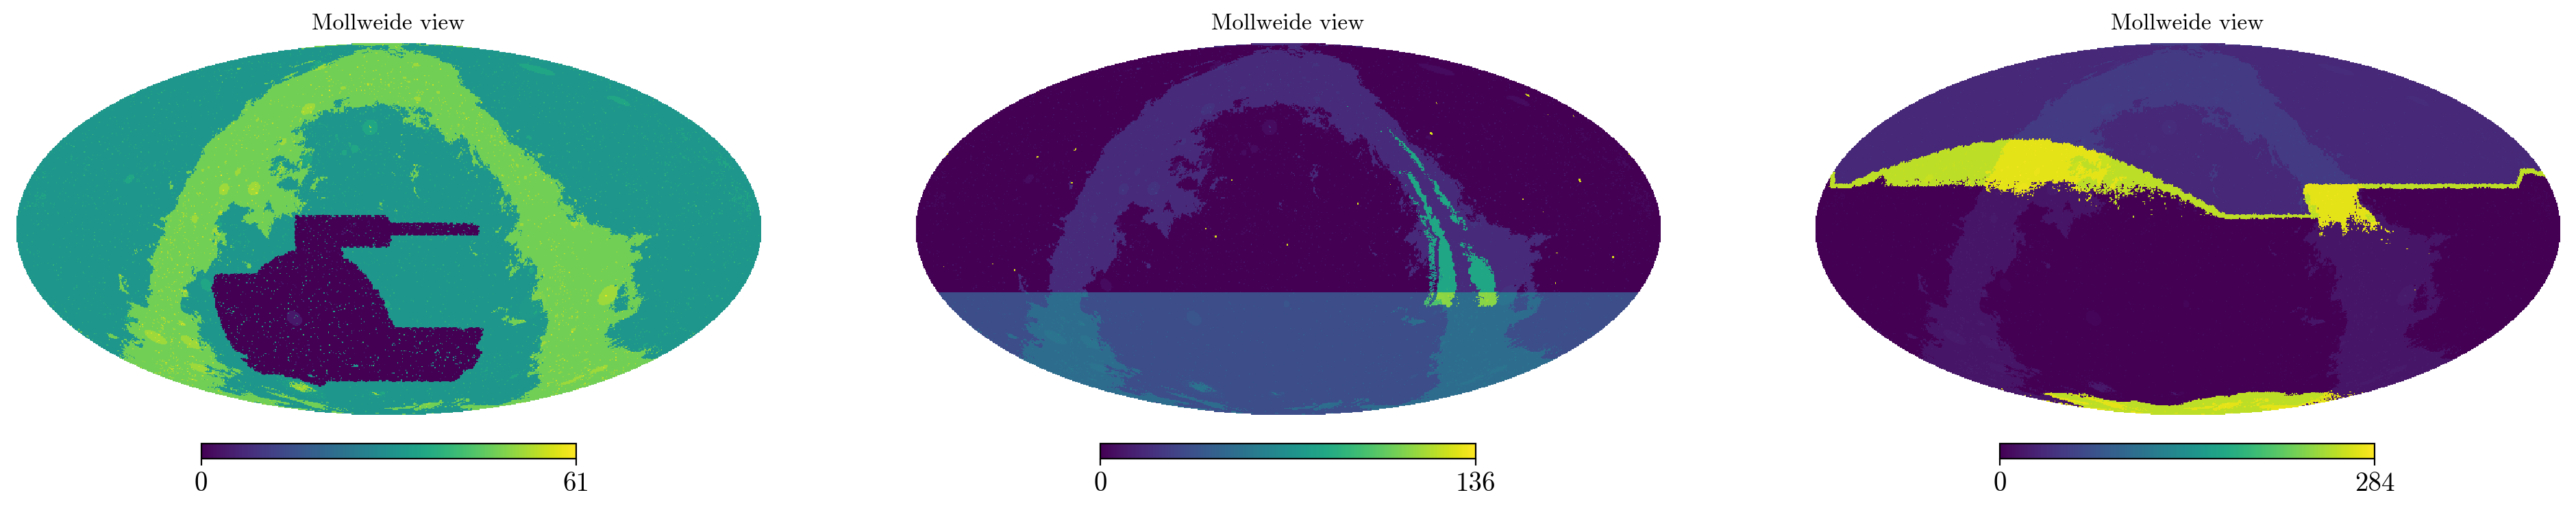

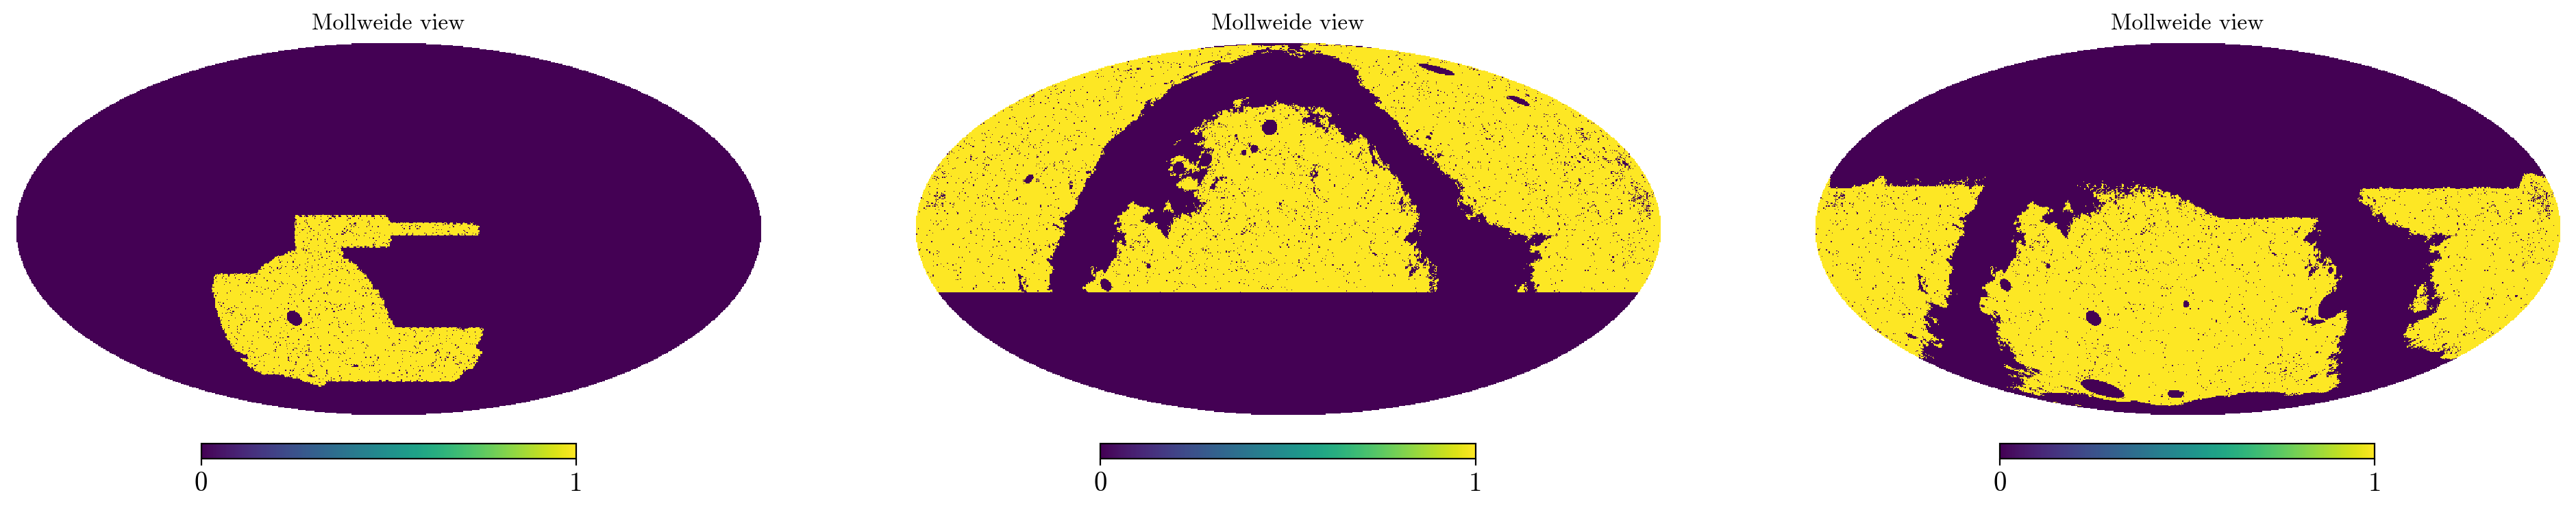

In [6]:
# Plot the survey masks
fig,ax = plt.subplots(1,3, figsize=(24,5))
for i, survey in enumerate(['des','ps1','lsst']):
    plt.sca(ax[i]); hp.mollview(masks[survey],hold=1,nest=True)

# The analysis only uses values where mask == 0
fig,ax = plt.subplots(1,3, figsize=(24,5))
for i, survey in enumerate(['des','ps1','lsst']):
    plt.sca(ax[i]); hp.mollview(masks[survey] == 0,hold=1,nest=True)
    area = (masks[survey] == 0).sum() * hp.nside2pixarea(hp.get_nside(masks[survey]), degrees=True)
    print(f"{survey} area: {area:0.1f} deg2")

           name  in_des
0     Antlia II   False
9        Carina   False
22       Fornax    True
30        Leo I   False
31       Leo II   False
35          LMC    True
44  Sagittarius   False
45     Sculptor    True
50          SMC    True
           name  in_ps1
0     Antlia II   False
9        Carina   False
22       Fornax   False
30        Leo I    True
31       Leo II    True
35          LMC    True
44  Sagittarius   False
45     Sculptor   False
50          SMC    True
           name  in_lsst
0     Antlia II    False
9        Carina     True
22       Fornax     True
30        Leo I     True
31       Leo II    False
35          LMC     True
44  Sagittarius    False
45     Sculptor     True
50          SMC     True


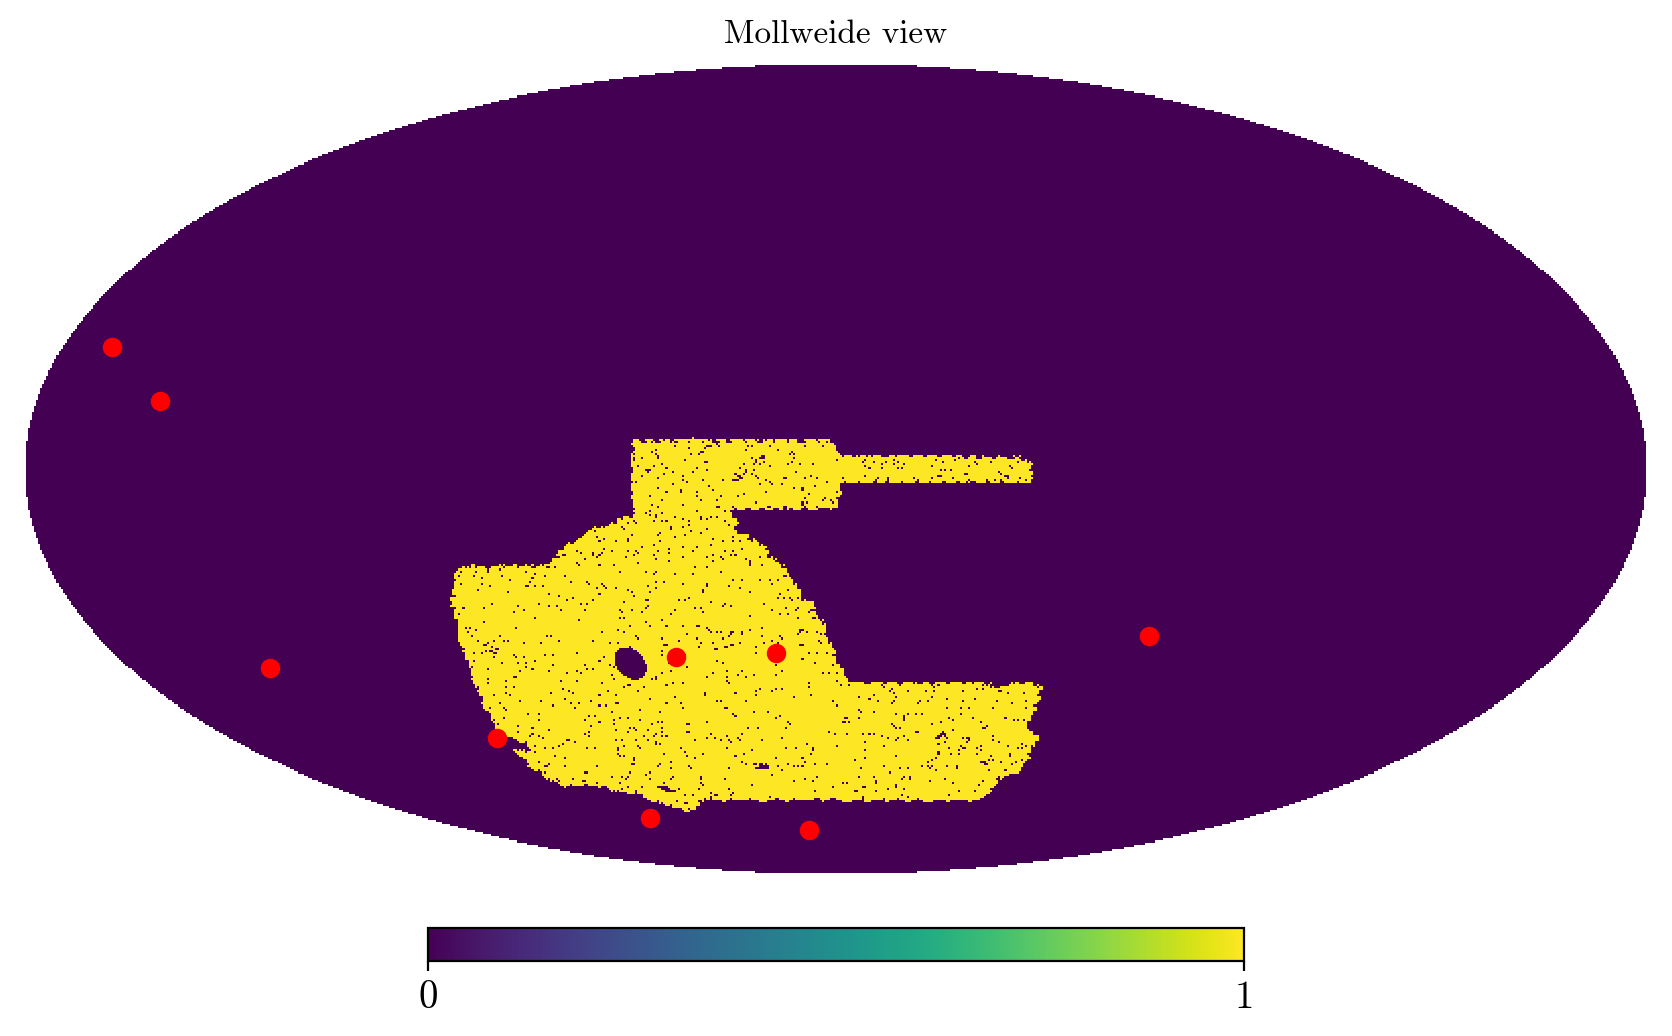

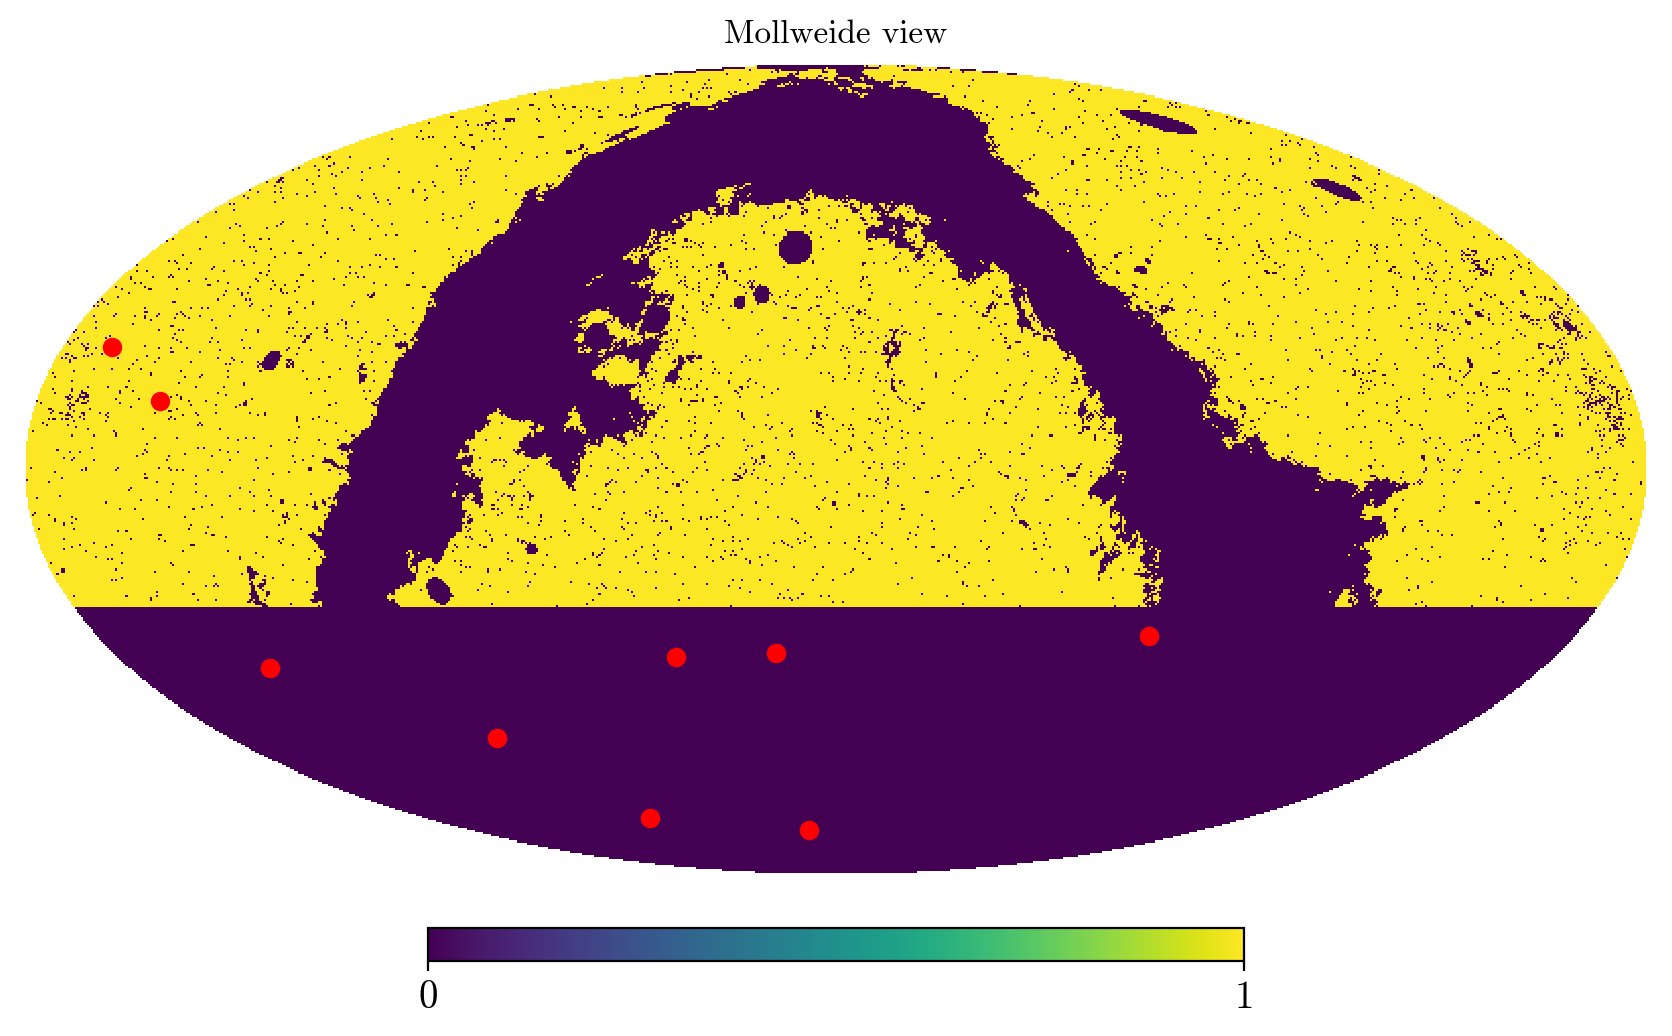

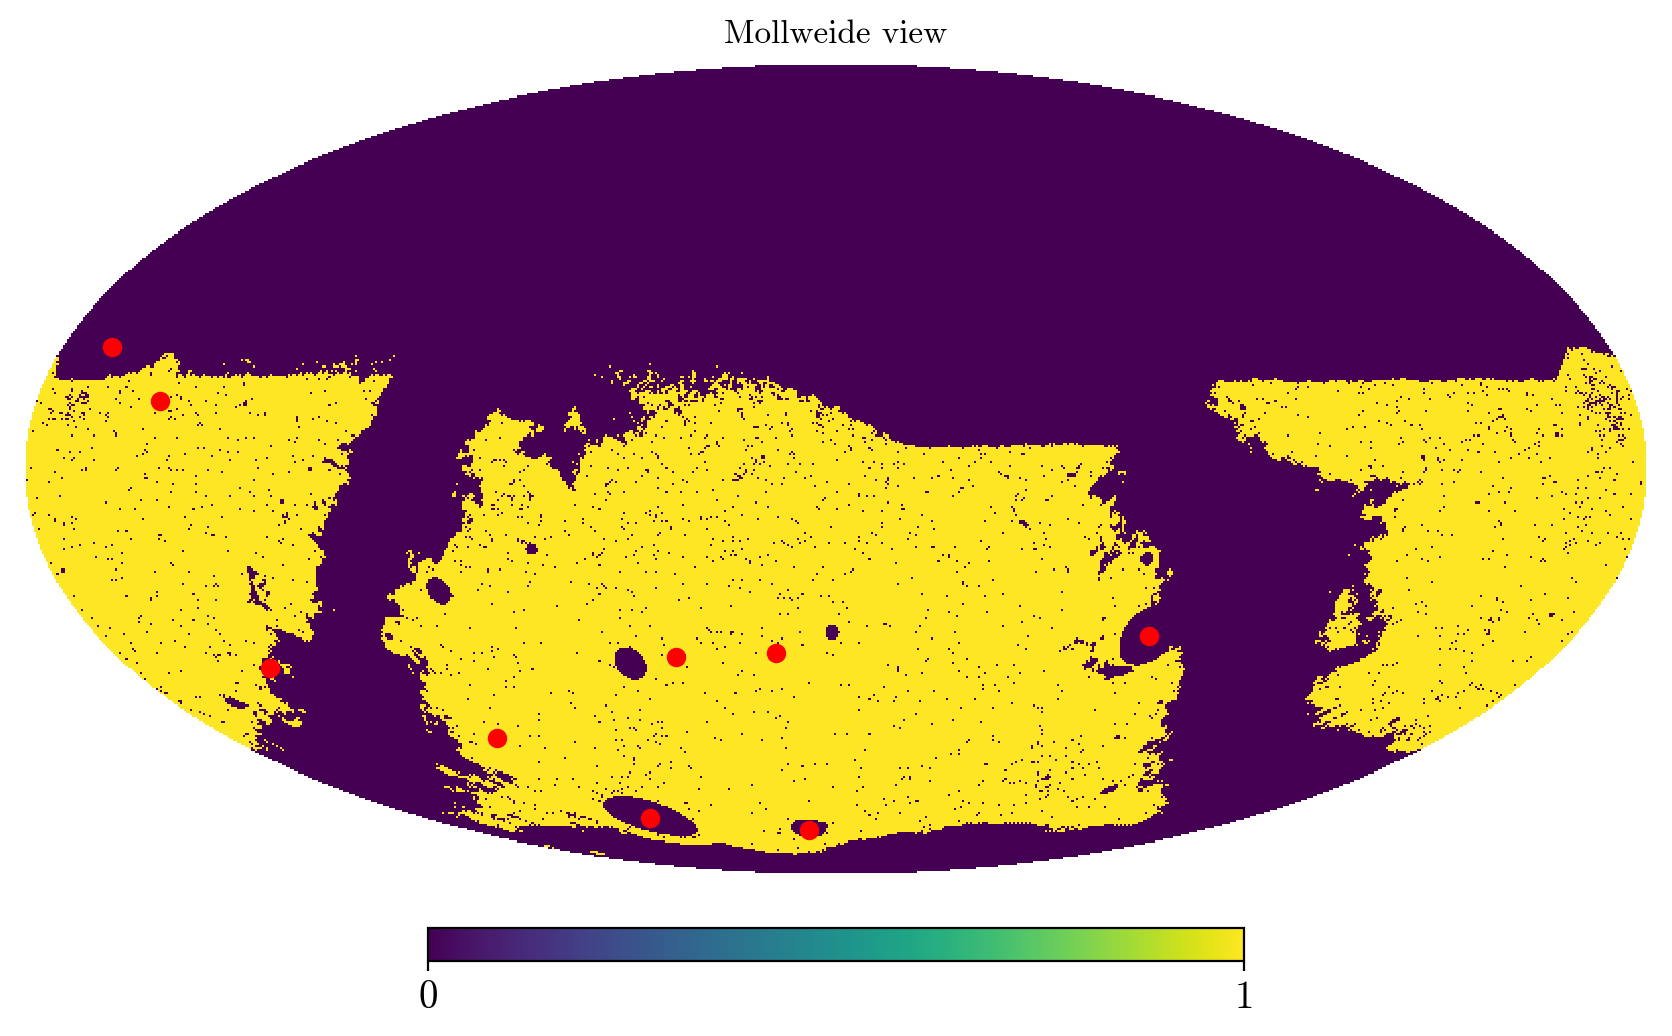

In [7]:
# The analysis only uses values where mask == 0
for survey in ['des','ps1','lsst']:
    hp.mollview(masks[survey] == 0,nest=True)
    #sel = confirmed_dwarfs[f'in_{survey}']
    sel = confirmed_dwarfs[f'M_V'] < -9
    print(confirmed_dwarfs[sel][['name',f'in_{survey}']])
    hp.projscatter(confirmed_dwarfs['ra'][sel],confirmed_dwarfs['dec'][sel], lonlat=True, color='r')

## Survey Selection Function Sanity Tests

This block performs some sanity checks on the survey selection functions. The basic check is to evaluate the SSF on a grid of absolute magnitude and size at a fixed distance.

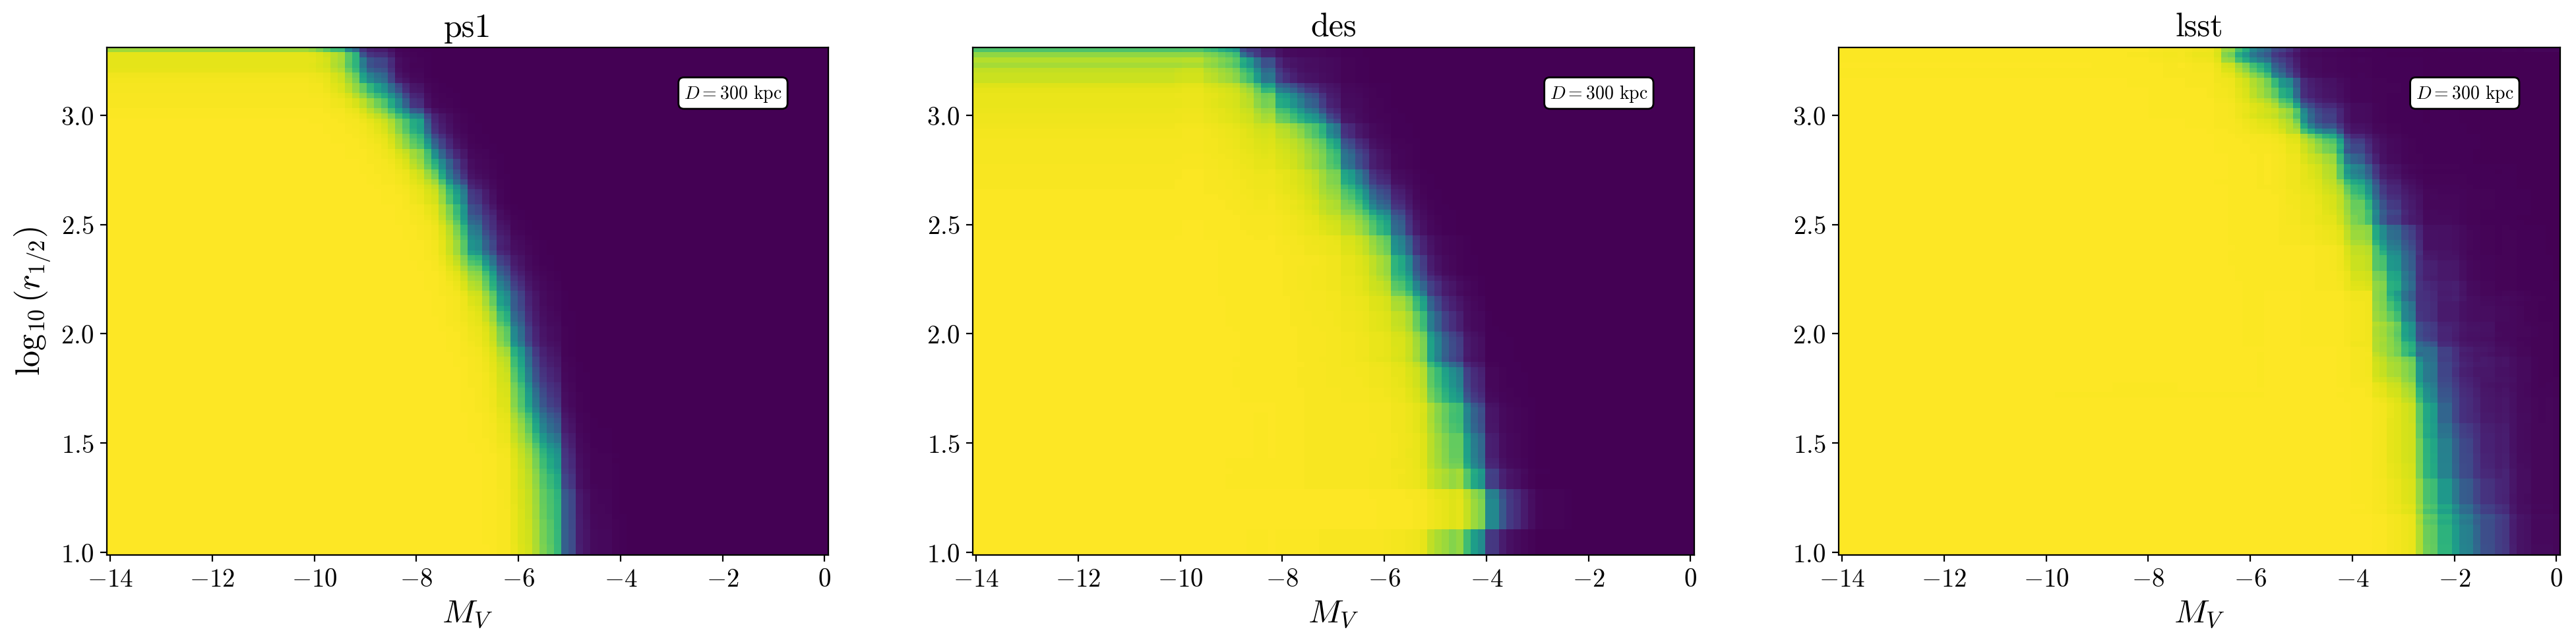

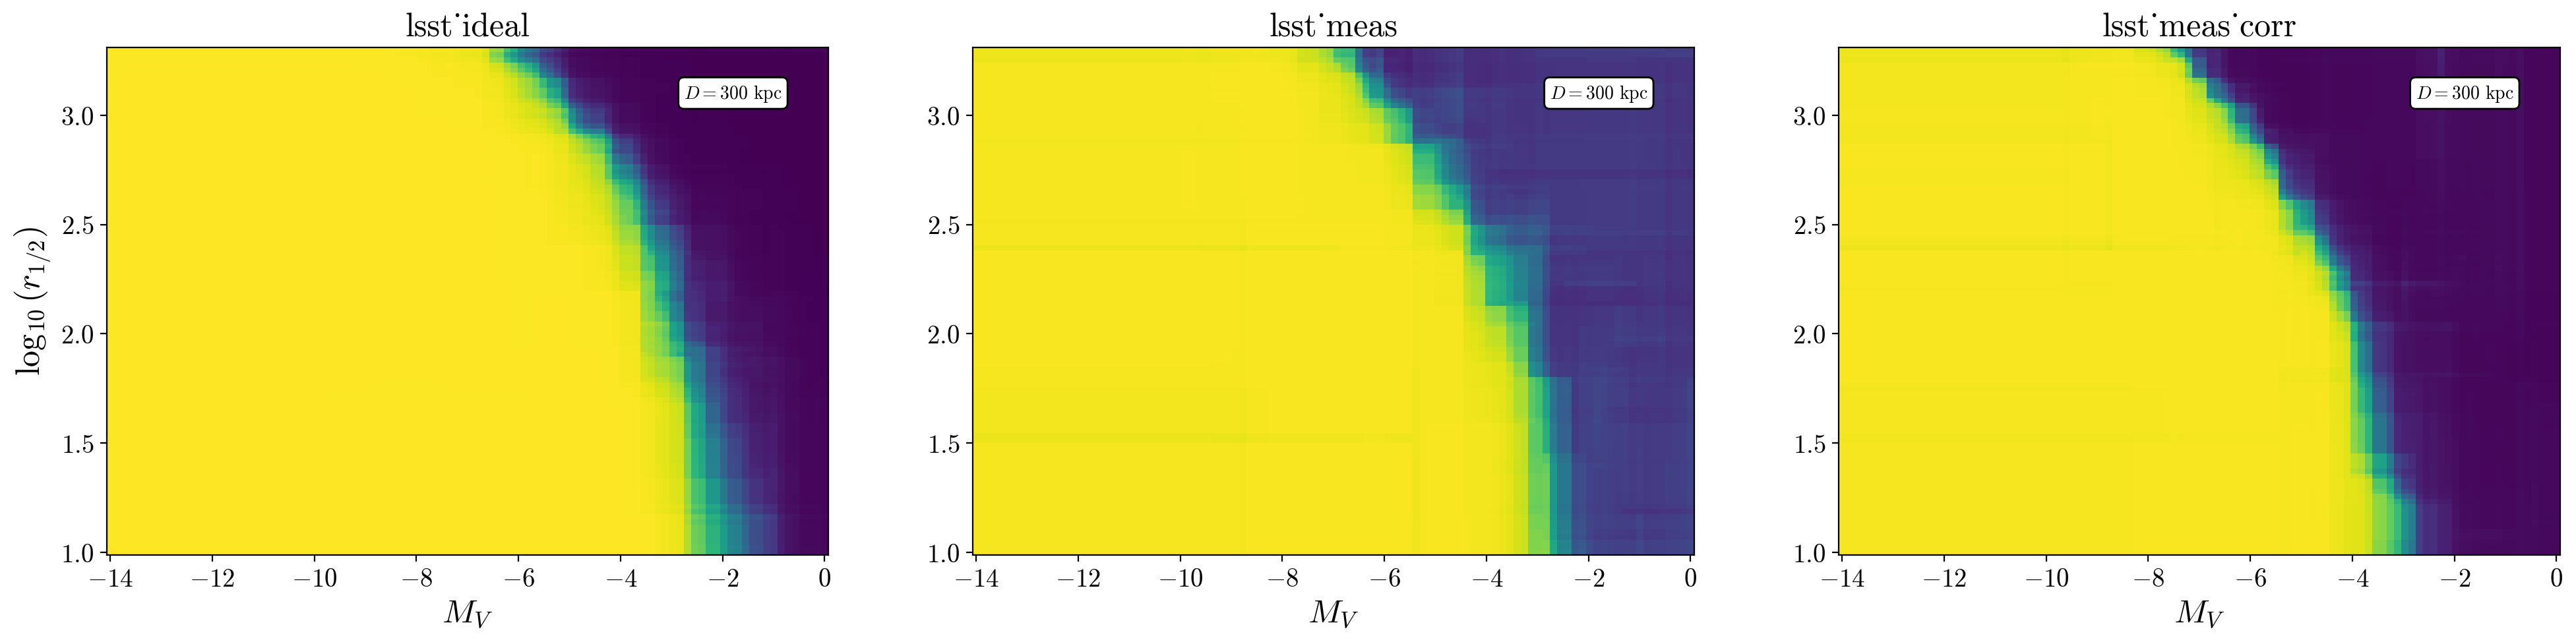

In [8]:
pc_to_kpc = 1e3
nedges = 100
Mv_bins = np.linspace(-14,0,nedges)
logr12_bins = np.linspace(1,3.3,nedges)
logdist_bins = np.linspace(1,2.5,nedges)

xx, yy = np.meshgrid(Mv_bins, logr12_bins)

abs_mag = xx.flatten()
r_physical = 10**(yy.flatten())
distance = 300*np.ones(xx.size)
ra = 50.0*np.ones(xx.size)
dec = 0.0*np.ones(xx.size)

# Calculate the detectability
surveys = ['ps1','des','lsst','lsst_ideal', 'lsst_meas', 'lsst_meas_corr', 'perfect']
pdet = dict()
for survey in surveys:
    kw = dict(abs_mag=abs_mag, distance=distance, ra=ra, dec=dec)
    kw['r_physical'] = r_physical/pc_to_kpc # This is done internally in ssf.apply_ssfs
    pdet[survey] = ssfs[survey].predict(**kw)

# Plot the SSFs
bbox=dict(facecolor='w', edgecolor='k', boxstyle='round')
fig,ax = plt.subplots(1,3, figsize=(24,5))
for i, survey in enumerate(['ps1','des','lsst']):
    ax[i].pcolormesh(xx,yy,pdet[survey].reshape(xx.shape), vmin=0, vmax=1.0)
    ax[i].annotate(f'$D={distance[0]:.0f}$ kpc',(0.8,0.9), xycoords='axes fraction', bbox=bbox)
    ax[i].set_title(survey,fontsize=18)
    if i == 0: ax[i].set_ylabel(r"$\log_{10}(r_{1/2})$",fontsize=18)
    ax[i].set_xlabel(r"$M_V$",fontsize=18)

# Plot the SSFs for various LSST S/G separations
fig,ax = plt.subplots(1,3, figsize=(24,5))
for i, survey in enumerate(['lsst_ideal','lsst_meas','lsst_meas_corr']):
    ax[i].pcolormesh(xx,yy,pdet[survey].reshape(xx.shape), vmin=0, vmax=1.0)
    ax[i].annotate(f'$D={distance[0]:.0f}$ kpc',(0.8,0.9), xycoords='axes fraction', bbox=bbox)
    ax[i].set_title(survey,fontsize=18)
    if i == 0: 
        ax[i].set_ylabel(r"$\log_{10}(r_{1/2})$",fontsize=18)
    ax[i].set_xlabel(r"$M_V$",fontsize=18)

## Plot of Spatial Randomization

This is the figure showing the change in significance ($\Delta$(SIG) = SIG$_{DC2}$ - SIG$_{rand}$) for blank sky regions in DC2.

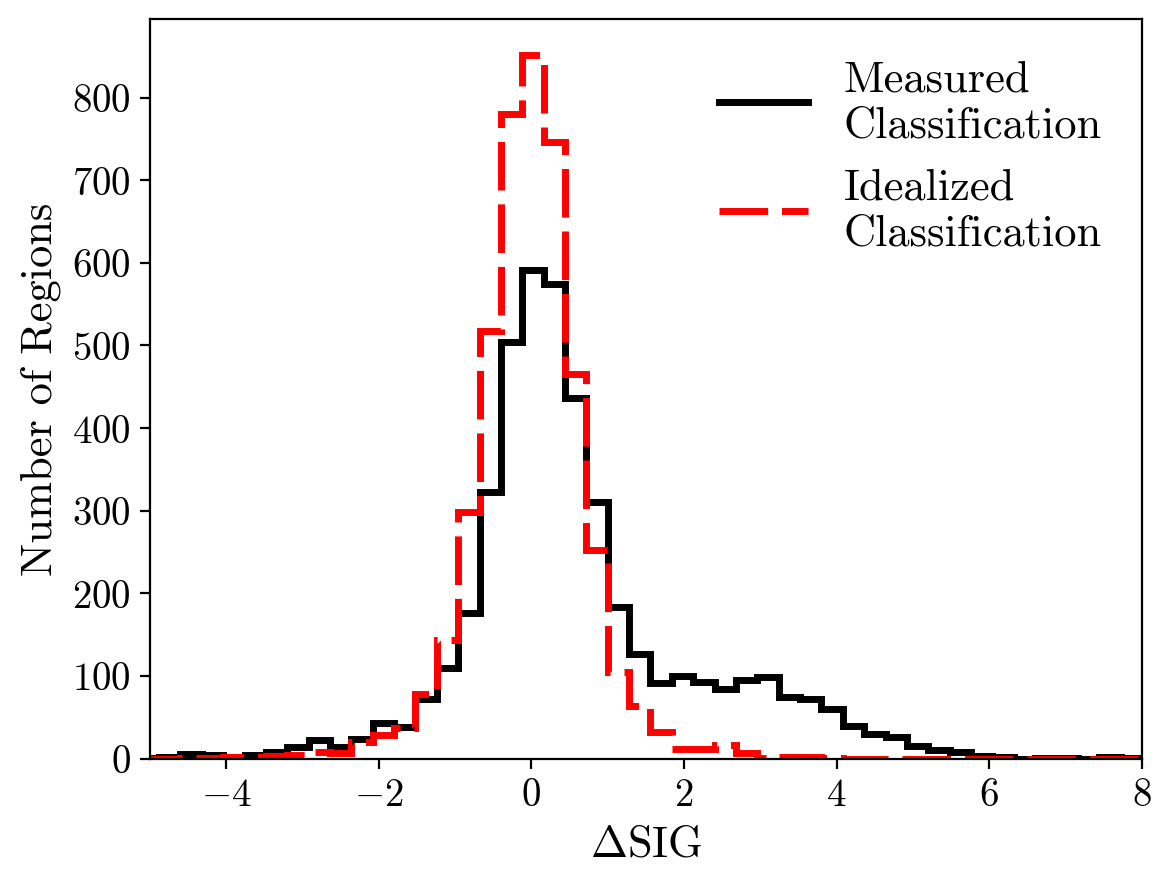

In [9]:
import pylab as plt
import pandas as pd

dirname = f'{SATSIM}/analysis/simple_adl/notebooks'
df1 = pd.read_csv(f'{dirname}/background_test_df.csv')[:4500]
df2 = pd.read_csv(f'{dirname}/background_test2_df.csv')[:4500]

fig, ax = plt.subplots(1,1)
#fig.suptitle('Background model test')

kw = dict(bins=np.linspace(-6,8,51), histtype='step', lw=2.5)
ax.hist(df1['delta sig'], color='k', **kw)
ax.plot(np.nan,np.nan, color='k', lw=kw['lw'], label='Measured\nClassification')
ax.hist(df2['delta sig'], color='r', ls=(0,(7,2)), **kw)
ax.plot(np.nan,np.nan, color='r', lw=kw['lw'], ls=(0,(7,2)), label='Idealized\nClassification')
plt.legend(frameon=False, fontsize=16)
ax.set_ylabel("Number of Regions", fontsize=16)
ax.set_xlabel(r'$\Delta$SIG', fontsize=16)
ax.set_xlim(-5,8)

plt.savefig('randomize_background.pdf')
#plt.savefig('background_model_test4.png')
plt.show()

## Predicted Luminosity Function

This puts the pieces together to generate and plot the predicted luminosity function of satellites observable with LSST.

In [10]:
from satellite_summary_stats import N_gr_Mr_new

def count_Mr(Mr,bins,prob,Mr_max):
    """
    Args:
        Mr (array of floats): Magnitude of each satellite
        bins (array of floats): Magnitude bins
        prob (array of floats): detection probability of each satellite
        Mr_max (float): dimmest magnitude considered
    
    Returns:
        Number of detected satellites in each magnitude bin.
    """
    idx = np.isfinite(Mr)
    idx_in_bins = (Mr>=bins[0]) & (Mr<=bins[-1]) & (Mr<=Mr_max)

    #un-normed distribution
    count_Mr = np.histogram(Mr[idx],bins=bins,weights=prob[idx],density=False)[0]

    return count_Mr

In [11]:
samples = np.loadtxt('samples_DES_beta0_O1_5param_update_fgal_size_conc_2D_new_density_fixed.txt')
samples2 = np.loadtxt('samples_DES_beta0_O1_5param_update_fgal_size_conc_2D_new_density_fixed_two.txt')
samples_all = np.concatenate((samples,samples2))

samples_all[:,2] = samples_all[:,2]-np.log10(0.7)
samples_all[:,5] = 1000.*samples_all[:,5]

In [12]:
cumulative_bins = np.linspace(-20,0,10)
diff_bins = np.linspace(-20,0,7)
def observed_satellite_realizations(surveys=['lsst'], 
                                    cumulative_bins=cumulative_bins, 
                                    diff_bins=diff_bins, 
                                    n_realizations=5, 
                                    size=1000):
    """
    Parameters
    ----------
    survey (list) : list of survey names to iterate over.
    cumulative_bins : bins in Mr within which the cumulative luminosity function is calculated.
    diff_bins : bins in Mr within which the differential luminosity function is calculated.
    n_realizations : number of realizations to sample
    size : number of samples to draw from realization.

    Returns
    -------
    N_Mr, N_gr_Mr, sats : differential number of satellites, cumulative number of satellites, and last satellite realization
    """
    N_Mr = {s: [] for s in surveys}
    N_gr_Mr = {s: [] for s in surveys}
    sats = {s: [] for s in surveys}
    idx = np.random.randint(len(samples_all),size=size)
    for alpha, sigma_M, M50, B, sigma_mpeak, A, sigma_r, n in samples_all[idx]:
        param_vector = [alpha,sigma_M,M50,sigma_mpeak,B,A,sigma_r,n,0.1]
        combined_satellite_properties_list, mock_counts = satellite_realization(
            param_vector,
            hparams,cosmo_params,orphan_params,
            halo_data,sim_indices,
            vpeak_Mr_interp,masks,ssfs,'cdm',
            surveys
        )
        ###
        for i in range(len(combined_satellite_properties_list)):
            for j in range(n_realizations):
                ind = combined_satellite_properties_list[i]['r12'] > 10.
                for survey in surveys:
                    ### Flag for whether satellite is in the survey footprint
                    flags = combined_satellite_properties_list[i]['{}_flags'.format(survey)]

                    ### All bright satellites 100% detectable; but disruption probability remains
                    #sel = combined_satellite_properties_list[i]['Mr'] < -8
                    #combined_satellite_properties_list[i]['pdet'][sel] = combined_satellite_properties_list[i]['prob'][sel]
                    ### All bright satellites 100% detectable and undisrupted
                    #combined_satellite_properties_list[i]['pdet'][sel] = 1.0
                    
                    ### Magellanic Cloud analog are always in survey, exist, and are detected
                    flags[0:2] = True
                    combined_satellite_properties_list[i]['pdet'][0:2] = 1.0

                    ### If combining DES and PS1, then don't count the MCs in PS1
                    if ('des' in surveys) and (survey == 'ps1'): 
                        flags[0:2] = False
                                  
                    ### Satellite properties
                    Mr = combined_satellite_properties_list[i]['Mr'][ind & flags]
                    radii = combined_satellite_properties_list[i]['radii'][ind & flags]
                    prob = combined_satellite_properties_list[i]['pdet'][ind & flags]

                    ### Consistent output weights
                    combined_satellite_properties_list[i]['weight'] = np.zeros(len(flags))
                    combined_satellite_properties_list[i]['weight'][ind & flags] = prob
                    
                    ### Output values                  
                    N_Mr[survey].append(count_Mr(Mr,diff_bins,prob,0.))
                    N_gr_Mr[survey].append(N_gr_Mr_new(Mr,radii,prob,cumulative_bins,300.,-25.))
                    sats[survey].append(combined_satellite_properties_list[i])
                        
    for survey in surveys:
        N_Mr[survey] = np.array(N_Mr[survey])
        N_gr_Mr[survey] = np.array(N_gr_Mr[survey])

    return N_Mr, N_gr_Mr, sats

In [13]:
# For plotting purposes, scrape the 1sigma contours from Nadler et al. (2020) [1912.03303]
n20_bot_1sig = np.array([
    [-0.00000e+0, 1.69011e+2],
    [-7.32249e-1, 1.45518e+2],
    [-1.42456e+0, 1.25294e+2],
    [-2.30325e+0, 9.23865e+1],
    [-3.12870e+0, 6.89103e+1],
    [-3.90089e+0, 5.22939e+1],
    [-4.67308e+0, 3.96842e+1],
    [-5.33876e+0, 3.18959e+1],
    [-6.13757e+0, 2.39282e+1],
    [-7.09615e+0, 1.69480e+1],
    [-8.05473e+0, 1.31584e+1],
    [-8.58728e+0, 1.14616e+1],
    [-9.14645e+0, 9.21281e+0],
    [-9.81213e+0, 7.15412e+0],
    [-1.05577e+1, 5.24539e+0],
    [-1.14231e+1, 3.69421e+0],
    [-1.22352e+1, 3.38779e+0],
    [-1.28609e+1, 3.16110e+0],
    [-1.36464e+1, 1.66153e+0],
    [-1.44186e+1, 9.96551e-1],
])

n20_top_1sig = np.array([
    [-0.00000e+0, 2.64419e+2], 
    [-7.58876e-1, 2.22497e+2], 
    [-1.42456e+0, 1.89392e+2], 
    [-2.27663e+0, 1.43716e+2], 
    [-2.96893e+0, 1.15509e+2], 
    [-3.63462e+0, 8.96973e+1], 
    [-4.27367e+0, 7.12721e+1], 
    [-5.01923e+0, 5.37776e+1], 
    [-5.71154e+0, 4.15209e+1], 
    [-6.32396e+0, 3.26159e+1], 
    [-7.10947e+0, 2.39133e+1], 
    [-7.88166e+0, 1.93295e+1], 
    [-8.53402e+0, 1.61728e+1], 
    [-9.19970e+0, 1.22036e+1], 
    [-9.97189e+0, 8.79482e+0], 
    [-1.05843e+1, 7.35873e+0], 
    [-1.13831e+1, 5.84654e+0], 
    [-1.20754e+1, 4.94808e+0], 
    [-1.29808e+1, 4.04542e+0], 
    [-1.36464e+1, 3.66787e+0], 
    [-1.42855e+1, 3.30659e+0], 
    [-1.51509e+1, 2.39654e+0], 
    [-1.60429e+1, 1.73692e+0], 
    [-1.71213e+1, 1.18172e+0], 
    [-1.72411e+1, 9.89068e-1], 
])

n20_top_2sig = np.array([
    [-0.00000e+0, 3.15900e+2],
    [-9.71893e-1, 2.49520e+2],
    [-1.81065e+0, 1.97105e+2],
    [-2.75592e+0, 1.47008e+2],
    [-3.70118e+0, 1.04125e+2],
    [-4.51331e+0, 7.63410e+1],
    [-5.44527e+0, 5.37630e+1],
    [-6.35059e+0, 3.74311e+1],
    [-7.08284e+0, 2.77614e+1],
    [-8.02811e+0, 2.13081e+1],
    [-8.53402e+0, 1.85607e+1],
    [-9.31953e+0, 1.31478e+1],
    [-9.97189e+0, 9.86435e+0],
    [-1.07707e+1, 8.06537e+0],
    [-1.16627e+1, 6.40759e+0],
    [-1.28343e+1, 4.64316e+0],
    [-1.42589e+1, 4.48195e+0],
    [-1.53772e+1, 2.83003e+0],
    [-1.63891e+1, 1.88180e+0],
    [-1.71213e+1, 1.39567e+0],
    [-1.73876e+1, 1.00039e+0],
])

n20_bot_2sig = np.array([
    [-0.00000e+0, 1.19096e+2],
    [-6.52367e-1, 1.05532e+2],
    [-1.42456e+0, 9.08606e+1],
    [-2.27663e+0, 6.62332e+1],
    [-3.24852e+0, 4.63765e+1],
    [-4.26036e+0, 3.22862e+1],
    [-5.25888e+0, 2.42179e+1],
    [-6.35059e+0, 1.71518e+1],
    [-7.16272e+0, 1.30156e+1],
    [-8.00148e+0, 1.06417e+1],
    [-8.61391e+0, 9.11077e+0],
    [-9.46598e+0, 6.75665e+0],
    [-9.99852e+0, 5.58915e+0],
    [-1.06376e+1, 3.98232e+0],
    [-1.14364e+1, 2.63321e+0],
    [-1.28609e+1, 2.69190e+0],
    [-1.36331e+1, 1.68072e+0],
    [-1.42589e+1, 9.96653e-1],
])

def plot_lines_n20():
    ax = plt.gca()
    ax.plot(n20_top_1sig[:,0], n20_top_1sig[:,1], color='b', ls='--', label=r'Total Population (Nadler+20)')
    ax.plot(n20_bot_1sig[:,0], n20_bot_1sig[:,1], color='b', ls='--')
    ax.plot(n20_top_2sig[:,0], n20_top_2sig[:,1], color='b', ls=':')
    ax.plot(n20_bot_2sig[:,0], n20_bot_2sig[:,1], color='b', ls=':')

def plot_patches_n20():
    ax = plt.gca()

    path_1sig = Path(np.concatenate([n20_top_1sig, n20_bot_1sig[::-1]]) )
    patch_1sig = PathPatch(path_1sig, facecolor="#9DB2C1",alpha=1.0, ec='none', label='Fiducial Satellite Population\n(Nadler et al. 2020)')
    path_2sig = Path(np.concatenate([n20_top_2sig, n20_bot_2sig[::-1]]) )
    patch_2sig = PathPatch(path_2sig, facecolor="#DDEBEF",alpha=1.0, ec='none')
    
    ax.add_artist(patch_2sig)
    ax.add_artist(patch_1sig)

In [14]:
# This is the main loop over survey selection functions.
# It can take >15m depending on sampling parameters.
surveys  = []
surveys += ['lsst_ideal', 'lsst_meas', 'lsst_meas_corr'] # Real SSFs and real footprint
# Sanity checks
#surveys += ['perfect',] # Perfect SSF and all-sky
#surveys += ['perfect_lsst',] # Perfect SSF and real footprint
#surveys += ['lsst_allsky', 'des_allsky', 'ps1_allsky'] # Real SSFs and all-sky
#surveys += ['des', 'ps1'] # Real SSFs and real footprints

cumulative_bins = np.linspace(-20,0,15)
diff_bins = np.linspace(-20,0,11)

kwargs = dict(cumulative_bins=cumulative_bins, diff_bins=diff_bins)
              
if False:
    kwargs.update(n_realizations=3, size=100)
else:
    kwargs.update(n_realizations=10, size=1000)

N_Mr, N_gr_Mr, sats = dict(), dict(), dict()
for survey in surveys:
    print(f"Running {survey}...")
    np.random.seed(42)
    _N_Mr, _N_gr_Mr, _sats = observed_satellite_realizations(surveys=[survey], **kwargs)
    N_Mr[survey] = _N_Mr[survey]
    N_gr_Mr[survey] = _N_gr_Mr[survey]
    sats[survey] = _sats[survey]

Running lsst_ideal...
Running lsst_meas...
Running lsst_meas_corr...


In [15]:
idx = -1

sel = (confirmed_dwarfs[f'in_{survey}']) & (confirmed_dwarfs['M_V'] < 0)
print(f"Known Dwarfs in LSST Footprint: {sel.sum()}\n")

for survey in ['lsst_ideal', 'lsst_meas', 'lsst_meas_corr']:
    if survey not in N_gr_Mr: continue
    mean = np.mean(N_gr_Mr[survey],axis=0)
    std = np.std(N_gr_Mr[survey],axis=0)
    abs_mag = cumulative_bins+0.2
    print(f"{survey} ({abs_mag[idx]}):")
    print(f"{mean[idx]:.2f} +/- {std[idx]:.2f}")
    print(f"{mean[idx] - sel.sum():.2f} +/- {std[idx]:.2f}")

Known Dwarfs in LSST Footprint: 36

lsst_ideal (0.2):
88.95 +/- 19.98
52.95 +/- 19.98
lsst_meas (0.2):
83.12 +/- 18.02
47.12 +/- 18.02
lsst_meas_corr (0.2):
67.10 +/- 14.25
31.10 +/- 14.25


## Plotting Luminosity Function and Satellite Characteristics

Here we plot the predicted luminosity function and the characteristics of detectable satellites.

In [16]:
survey='perfect'
if survey in N_gr_Mr:
    f, ax = plt.subplots(1, 1, sharey=True, figsize=(10,8))
    
    sel = confirmed_dwarfs[f'in_{survey}']
    kw = dict(bins=np.linspace(-19,0.1), lw=3, color='r', histtype='step', cumulative=1, zorder=999)
    plt.hist(confirmed_dwarfs['M_V'][sel], **kw)
    plt.plot(np.nan, np.nan, color=kw['color'], lw=kw['lw'], label='Observed Satellites (All-Sky)')
    
    ax.semilogy(cumulative_bins+0.2,np.mean(N_gr_Mr['perfect'],axis=0),'b',linewidth=2.5,zorder=998,
                label='Perfect Survey')
    ax.semilogy(cumulative_bins+0.2,np.mean(N_gr_Mr['lsst_allsky'],axis=0),'g',linewidth=2.5,zorder=998,
                label='LSST All-Sky')
    ax.semilogy(cumulative_bins+0.2,np.mean(N_gr_Mr['des_allsky'],axis=0),'m',linewidth=2.5,zorder=998,
                label='DES All-Sky')
    ax.semilogy(cumulative_bins+0.2,np.mean(N_gr_Mr['ps1_allsky'],axis=0),'cyan',linewidth=2.5,zorder=998,
                label='PS1 All-Sky')
    
    ax.fill_between(cumulative_bins+0.2,np.mean(N_gr_Mr[survey],axis=0)-np.std(N_gr_Mr[survey],axis=0),
                    np.mean(N_gr_Mr[survey],axis=0)+np.std(N_gr_Mr[survey],axis=0),
                    facecolor="#003660",alpha=0.3,zorder=990)
    ax.fill_between(cumulative_bins+0.2,np.mean(N_gr_Mr[survey],axis=0)-2.*np.std(N_gr_Mr[survey],axis=0),
                    np.mean(N_gr_Mr[survey],axis=0)+2.*np.std(N_gr_Mr[survey],axis=0),
                    facecolor="#04859B",alpha=0.15,zorder=990) #,label=r'$2\sigma$ Confidence Interval')
    
    plot_lines_n20()
    
    ax.set_xlim(-17.5,0)
    ax.set_ylim(1,250)
    ax.set_xticks([-15, -12,-9,-6,-3,0])
    ax.set_xticklabels([-15, -12, -9,-6,-3,0],fontsize=18)
    ax.set_yticks([1,2,5,10,20,50,100,200])
    ax.set_yticklabels([1,2,5,10,20,50,100,200],fontsize=18)
    ax.tick_params(labelbottom='off',which='minor')
    ax.set_xlabel(r'$M_{V}\ \rm{[mag]}$',fontsize=22)
    ax.set_ylabel(r'$N(<M_{V})$',fontsize=22,labelpad=8)
    
    handles, labels = ax.get_legend_handles_labels()
    handles[1] = (handles[1], Patch(color="#003660", alpha=0.3, linewidth=0))
    ax.legend(handles=handles, labels=labels, loc=1,prop={'size':18},frameon=False)
    
    plt.gca().invert_xaxis()
    #plt.text(-0.5,1.25,r'$\mathbf{%s}$'%(survey.upper()), fontweight='bold', fontsize=20)
    
    plt.show()

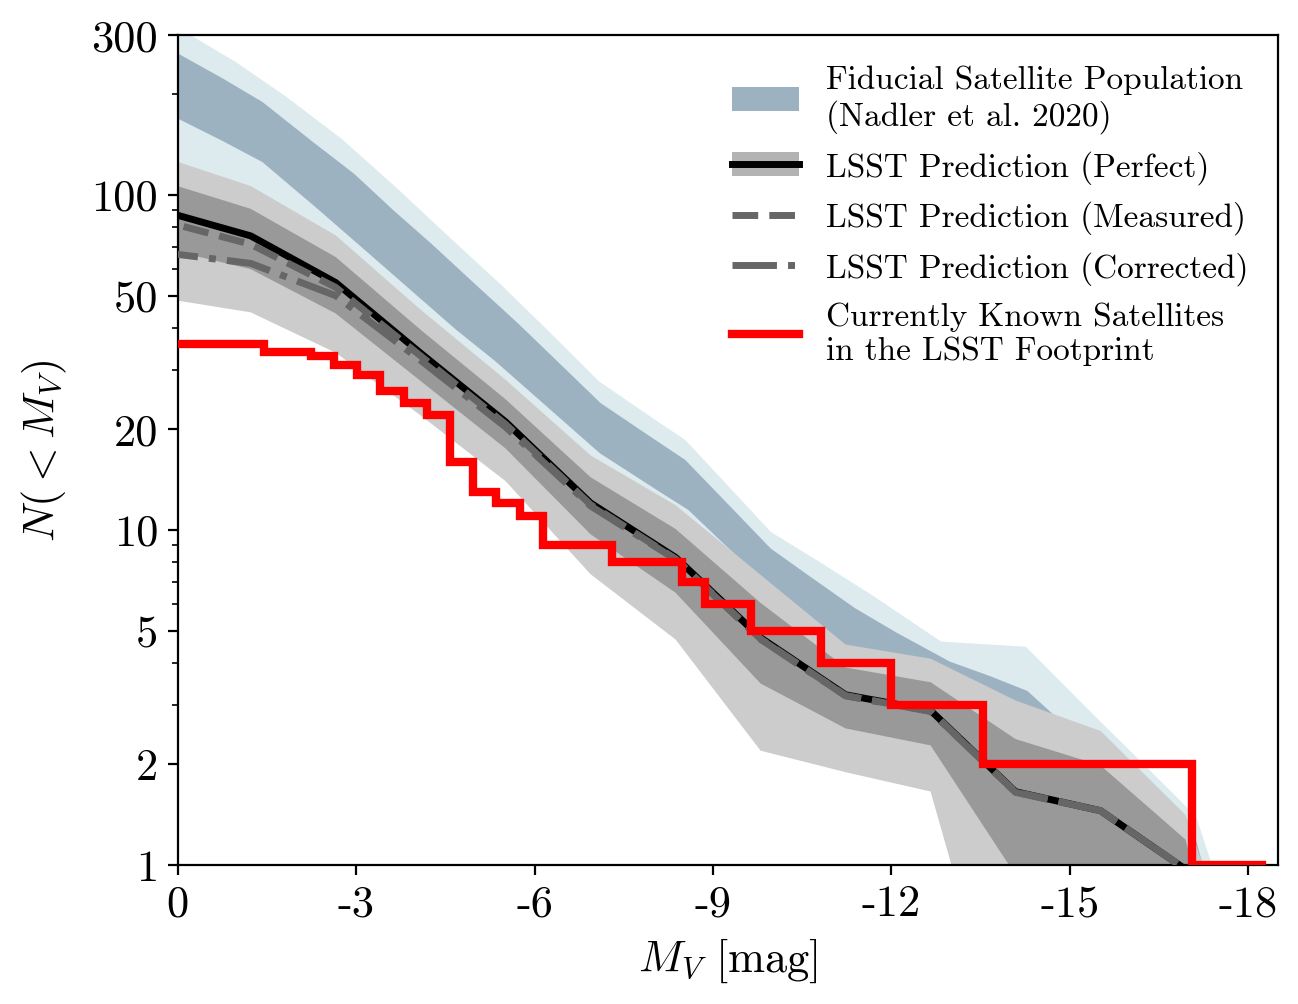

In [17]:
survey='lsst_ideal'
#f, ax = plt.subplots(1, 1, sharey=True, figsize=(10,8))
f, ax = plt.subplots(1, 1, sharey=True, figsize=(7.1,5))
plt.subplots_adjust(bottom=0.15, top=0.98)

#plot_lines_n20()
plot_patches_n20()

ax.semilogy(cumulative_bins+0.2,np.mean(N_gr_Mr['lsst_ideal'],axis=0),'k',linewidth=2.5,zorder=998,
            label='LSST Prediction (Perfect)')
ax.semilogy(cumulative_bins+0.2,np.mean(N_gr_Mr['lsst_meas'],axis=0),'0.4',ls='--', linewidth=2.5,zorder=998,
            label='LSST Prediction (Measured)')
ax.semilogy(cumulative_bins+0.2,np.mean(N_gr_Mr['lsst_meas_corr'],axis=0),'0.4',ls='-.',linewidth=2.5,zorder=998,
            label='LSST Prediction (Corrected)')

#ax.semilogy(cumulative_bins+0.2,np.mean(N_gr_Mr['perfect_lsst'],axis=0),'g',linewidth=2.5,zorder=998,
#            label='Fiducial (LSST Footprint)')

ax.fill_between(cumulative_bins+0.2,
                np.mean(N_gr_Mr[survey],axis=0)-2.*np.std(N_gr_Mr[survey],axis=0),
                np.mean(N_gr_Mr[survey],axis=0)+2.*np.std(N_gr_Mr[survey],axis=0),
                facecolor="0.8",alpha=1.0,zorder=1) 
ax.fill_between(cumulative_bins+0.2,
                np.mean(N_gr_Mr[survey],axis=0)-np.std(N_gr_Mr[survey],axis=0),
                np.mean(N_gr_Mr[survey],axis=0)+np.std(N_gr_Mr[survey],axis=0),
                facecolor="0.6",alpha=1.0,zorder=1)

sel = confirmed_dwarfs[f'in_{survey}']
kw = dict(bins=np.linspace(-19,0.1), lw=3, color='r', histtype='step', cumulative=1, zorder=999)
plt.hist(confirmed_dwarfs['M_V'][sel], **kw)
plt.plot(np.nan, np.nan, color=kw['color'], lw=kw['lw'], label='Currently Known Satellites\nin the LSST Footprint')

ax.set_xlim(-18.5,0)
ax.set_xticks([-18, -15, -12,-9,-6,-3,0])
ax.set_xticklabels([-18, -15, -12, -9,-6,-3,0], fontsize=16)
ax.set_ylim(1,250)
ax.set_yticks([1,2,5,10,20,50,100,300])
ax.set_yticklabels([1,2,5,10,20,50,100,300], fontsize=16)
ax.tick_params(labelbottom='off',which='minor')
ax.set_xlabel(r'$M_{V}\ \rm{[mag]}$',fontsize=16)
ax.set_ylabel(r'$N(<M_{V})$',fontsize=16,labelpad=8)

handles, labels = ax.get_legend_handles_labels()
handles[1] = (Patch(color="0.7", alpha=1.0, linewidth=0), handles[1])
ax.legend(handles=handles, labels=labels, loc=1, prop={'size': 12},frameon=False)

plt.gca().invert_xaxis()

outfile = 'lsst_luminosity_function.pdf'
plt.savefig(outfile)
plt.savefig(outfile.replace('.pdf','.png'))

plt.show()

In [18]:
len(cumulative_bins)
len(np.mean(N_gr_Mr[survey],axis=0))

15

In [19]:
survey = 'lsst_ideal'
r12 = np.concatenate([s['r12'] for s in sats[survey]])
Mv = np.concatenate([s['Mr'] for s in sats[survey]]) + 0.2
dist = np.concatenate([LA.norm(s['rotated_pos'], axis=1) for s in sats[survey]])
weight = np.concatenate([s['weight'] for s in sats[survey]])

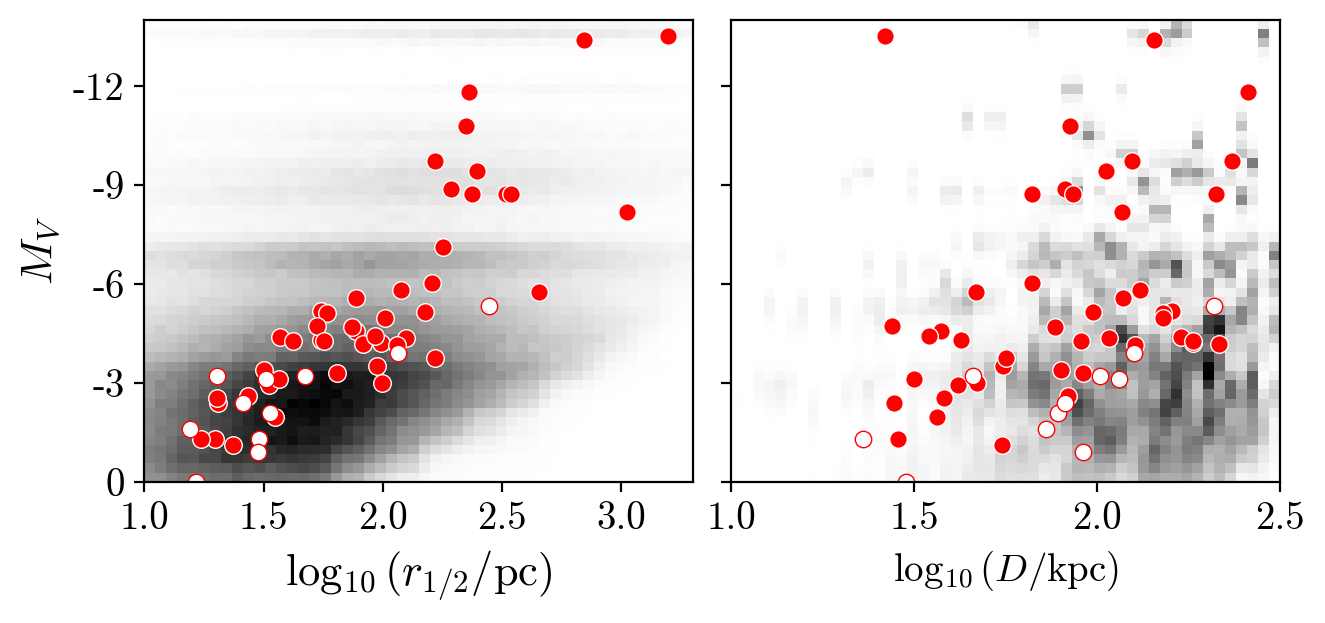

In [20]:
#fig, ax = plt.subplots(1,2, figsize=(14,7), sharey=True)
fig, ax = plt.subplots(1,2, figsize=(7.1,3), sharey=True)
plt.subplots_adjust(wspace=0.07, bottom=0.2, top=0.97, left=0.12, right=0.92)

nedges = 51
Mv_bins = np.linspace(-14,0,nedges)
logr12_bins = np.linspace(1,3.3,nedges)
logdist_bins = np.linspace(1,2.5,nedges)

hist_kw = dict(cmap='gray_r')
pcol_kw = dict(cmap='gray_r', rasterized=True)
conf_kw = dict(s=40, marker='o', c='r', ec='w', linewidth=0.5)
cand_kw = dict(s=35, marker='o', fc='w', ec='r', linewidth=0.5)

#ax[0].hist2d(np.log10(r12), Mv, bins=[logr12_bins, Mv_bins], weights=weight, **hist_kw)
values, _, _ = np.histogram2d(np.log10(r12), Mv, bins=[logr12_bins, Mv_bins], weights=weight)
smooth = nd.gaussian_filter(values, 0)
pcol = ax[0].pcolormesh(logr12_bins, Mv_bins, smooth.T, **pcol_kw)
ax[0].scatter(np.log10(confirmed_dwarfs['rhalf_sph_physical']), confirmed_dwarfs['M_V'], **conf_kw)
ax[0].scatter(np.log10(candidate_dwarfs['rhalf_sph_physical']), candidate_dwarfs['M_V'], **cand_kw)
ax[0].set_ylabel(r"$M_V$", fontsize=16)
ax[0].set_xlabel(r"$\log_{10}(r_{1/2}/{\rm pc})$", fontsize=16)
ax[0].set_xticks([1, 1.5, 2, 2.5, 3.0])
ax[0].set_xticklabels(ax[0].get_xticks(), fontsize=14)
ax[0].set_xlim(logr12_bins.min(), logr12_bins.max())
ax[0].set_yticks([0, -3, -6, -9, -12])
ax[0].set_yticklabels(ax[0].get_yticks(), fontsize=14)
ax[0].set_ylim(Mv_bins.max(), Mv_bins.min())

#ax[1].hist2d(np.log10(dist), Mv, bins=[logdist_bins, Mv_bins], weights=weight, **hist_kw)
values, _, _ = np.histogram2d(np.log10(dist), Mv, bins=[logdist_bins, Mv_bins], weights=weight)
smooth = nd.gaussian_filter(values, 0)
ax[1].pcolormesh(logdist_bins, Mv_bins, smooth.T, **pcol_kw)
ax[1].scatter(np.log10(confirmed_dwarfs['distance']), confirmed_dwarfs['M_V'], **conf_kw)
ax[1].scatter(np.log10(candidate_dwarfs['distance']), candidate_dwarfs['M_V'], **cand_kw)
ax[1].set_xlabel(r"$\log_{10}(D/{\rm kpc})$", fontsize=14)
ax[1].set_xticks([1, 1.5, 2, 2.5])
ax[1].set_xticklabels(ax[1].get_xticks(), fontsize=14)
ax[1].set_xlim(logdist_bins.min(), logdist_bins.max())

plt.savefig('lsst_dwarf_properties.pdf')
#ax[0].text(1.1,-13,r'$\mathbf{%s}$'%(survey.replace('_',r'\ ').upper()), fontweight='bold', fontsize=20)